# Final Assignment (FastMRI)
## Group 42

### Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import h5py, os
import numpy as np
from torch.utils.data import DataLoader
from functions import transforms as T
from functions.subsample import MaskFunc
from scipy.io import loadmat
from matplotlib import pyplot as plt
import csv
import time
from models import models42 as m42

### Load Datapath

In [34]:
# Paths of Training Data
wp='PC'
if wp=='PC':
    data_path_train = '/data/local/NC2019MRI/train'
    data_path_val = '/data/local/NC2019MRI/train'
    
    model_dir='/home/students/lxr863/Neural-Computation_G42-master/models'
    model_path='/home/students/lxr863/Neural-Computation_G42-master/models/CNN_4L.pth'


### Computational Resource Selection (GPU/CPU)

In [35]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'  # check whether a GPU is available
#device='cuda:0'
print(device)

cuda:0


### NN Model

In [36]:
# create a model
model = m42.CNN_4L().to(device)

# set learning rate
lr = 1e-2
# We also use stochastic gradient descent (SGD) to update a and b
#optimiser = optim.SGD(model.parameters(), lr=lr)
optimiser = optim.SGD(model.parameters(), lr=lr)
print(model)
####### Compute size of the output of the network ######
wh_in=320                             # height and width of the input image [320x320]px
inp=torch.randn(1,1,wh_in,wh_in).to(device)
print(inp.shape)
Output=model(inp)
wh_out=Output.shape
wh_out=(list(wh_out))
wh_out=wh_out[3]
print(wh_out)
#print(list(model.parameters()))

#for m in model.parameters():
#    print(m)

CNN_4L(
  (block1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
  (block2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
  (block3): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (block4): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (RELU): ReLU()
)
torch.Size([1, 1, 320, 320])
320


<class 'list'>
50
50


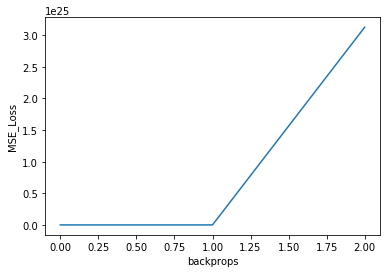

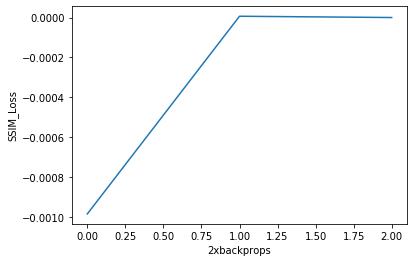

5.142410039901733 seconds# 0 minutes#


In [48]:
# Load the saved model hperparameters
checkpoint=(torch.load(model_path))
model.load_state_dict(checkpoint['model_state_dict'])
optimiser.load_state_dict(checkpoint['optimiser_state_dict'])
losses=checkpoint['Loss']
SSIMval=checkpoint['SSIM']
print(type(losses))
print(len(losses))
print(len(SSIMval))
plt.plot(range(len(losses)),losses,label="Training loss")
plt.xlabel("backprops")
plt.ylabel("MSE_Loss")
plt.show()
plt.plot(range(len(SSIMval)),SSIMval,label="SSIM loss")
plt.xlabel("2xbackprops")
plt.ylabel("SSIM_Loss")
plt.show()
print(sec,'seconds#',int(sec/60),'minutes#')

### Functions

In [39]:
def crop_img(data, width, height):
    return T.center_crop(data,[width,height])

def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

class MRIDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction, use_seed, cplx):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction
        self.use_seed = use_seed
        self.cplx=cplx

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]
        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed, self.cplx)

def get_epoch_batch(subject_id, acc, center_fract, use_seed=True, cplx=False):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name, slice = subject_id  
    Cplx=cplx
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace'][slice]
                      
    rawdata=crop_img(rawdata,320,320)
            
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape

    #print('raw',(rawdata).shape)
    #print((T.to_tensor_mod(rawdata).unsqueeze(0)).shape)
    
    slice_kspace_abs=torch.log(T.complex_abs(slice_kspace) + 1e-9)
    # apply random mask
    shape = np.array(slice_kspace.shape)
    mask_func = MaskFunc(center_fractions=[center_fract], accelerations=[acc])
    seed = None if not use_seed else tuple(map(ord, fname))
    mask = mask_func(shape, seed)
      
    # undersample
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)
    masks = mask.repeat(S, Ny, 1, ps)
    masked_kspace_abs=torch.log(T.complex_abs(masked_kspace) + 1e-9)

    img_gt, img_und = T.ifft2(slice_kspace), T.ifft2(masked_kspace)

    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: norm = 1e-6
    
    # normalized data
    img_gt, img_und, rawdata_und = img_gt/norm, img_und/norm, masked_kspace/norm
       
    img_gt=T.center_crop(T.complex_abs(img_gt),[320,320])
    img_und=T.center_crop(T.complex_abs(img_und),[320,320])
    #print('img_gt:',img_gt.shape)
    #return img_gt.squeeze(0), img_und.squeeze(0), rawdata_und.squeeze(0), masks.squeeze(0), norm
    if not Cplx:
        return img_und, img_gt # x is the undersampled image y is the ground truth
    else:
        return masked_kspace_abs, slice_kspace_abs

def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]
      
    for i in range(len(data_path)):

        data_list[train_and_val[i]] = []
        
        which_data_path = data_path[i]
    
        for fname in sorted(os.listdir(which_data_path)):
            
            subject_data_path = os.path.join(which_data_path, fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace'].shape[0]
                
            # the first 5 slices are mostly noise so it is better to exlude them
            data_list[train_and_val[i]] += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]
    
    return data_list    

def show_img(data, slice_nums, train_num, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[train_num,num], cmap=cmap)
        plt.axis('off')
        
from skimage.measure import compare_ssim 
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )
        
def train_onestep(model, lossfcn, optimiser):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

### Split Training Data into train and validation

In [40]:
num_files=len(os.listdir(data_path_train))
index=(np.arange(num_files))

np.random.seed(42)
np.random.shuffle(index)
# we will split the train and validate data by 80:20
train_index=np.sort(index[:int(num_files*0.8)])
validate_index=np.sort(index[int(num_files*0.8):])
print('train:',train_index)
print('validate:',validate_index)

#print((index))
idn=[]
# create dictionary contains the information about the traindata and validation data from train dataset
data_list = {}
data_list['train']=[]
data_list['validate']=[]
for idx,fname in enumerate(sorted(os.listdir(data_path_train))): 
    subject_data_path = os.path.join(data_path_train, fname)         
    if not os.path.isfile(subject_data_path): continue         
    with h5py.File(subject_data_path, 'r') as data:
            num_slice = data['kspace'].shape[0]
    if len(np.where(train_index==idx)[0]):
        data_list['train']+=[(fname,subject_data_path,slice) for slice in range(5,num_slice)]
        #data_list['train']+=[(fname,subject_data_path,slice) for slice in range(5,num_slice)]
        #print('train_filename:',fname)
    else:
        data_list['validate']+=[(fname,subject_data_path,slice) for slice in range(5,num_slice)]
        #data_list['validate']+=[(fname,subject_data_path,slice) for slice in range(5,num_slice)]
        #print('validate_filename:',fname)
        
print(len(data_list))
print(len(data_list['train']))
print(len(data_list['validate']))
#print((data_list['validate']))

train: [ 0  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 22 24 25 26 27 28 30
 31 32 33 34 35 36 38 39 40 41 42 44 45 46 47 48 49 50 53 54 55 56 57 58
 59 62 63 64 66 67 68 69]
validate: [ 1  2 14 20 21 23 29 37 43 51 52 60 61 65]
2
1699
435


### Load Specific Training Dataset

### NN Training

torch.Size([5, 1, 320, 320])
torch.Size([5, 1, 320, 320])


"\nfig = plt.figure(figsize=(15,10))\nplt.subplot(1,2,1)\nplt.imshow(x[0][0],cmap='gray')\nplt.title('undersampled real image')\nplt.axis('off')\nplt.subplot(1,2,2)\nplt.imshow(y[0][0],cmap='gray')\nplt.title('ground truth real image')\nplt.axis('off')\n"

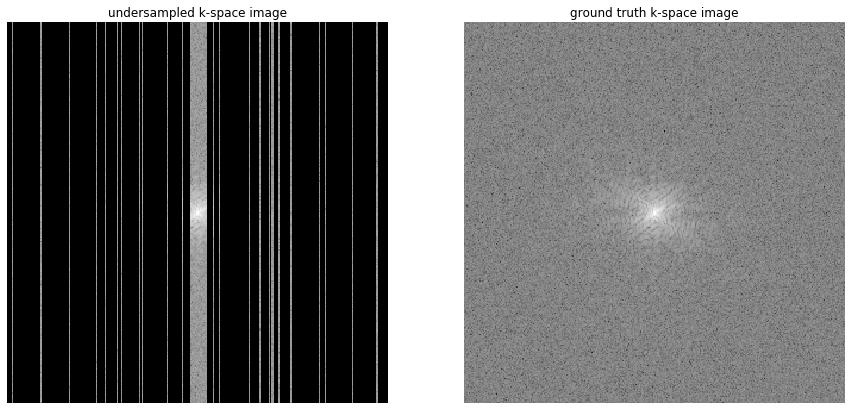

In [49]:
if __name__ == '__main__':
    
    #data_list = load_data_path(data_path_train, data_path_val) # first load all file names, paths and slices.
    #print(data_list)
    acc = 8
    cen_fract = 0.04
    seed = False # random masks for each slice 
    num_workers = 0 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    cplx = True # complex k-space data
    # create data loader for training set. It applies same to validation set as well
    train_dataset = MRIDataset(data_list['train'], acceleration=acc, center_fraction=cen_fract, use_seed=seed, cplx=cplx)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=5, num_workers=num_workers) 
    
    for iteration, sample in enumerate(train_loader):
        
        x, y = sample # x is the undersampled image y is the ground truth image
        
        print(x.shape)
        print(y.shape)

        if iteration >= 0: break  # show 4 random slices
    '''
    for iteration, sample in enumerate(train_loader):
        
        img_gt, img_und, rawdata_und, masks, norm, kspace = sample
        
        # stack different slices into a volume for visualisation
        A = masks[...,0].squeeze()
        B = torch.log(T.complex_abs(rawdata_und) + 1e-9).squeeze()
        C = T.complex_abs(img_und).squeeze()
        D = T.complex_abs(img_gt).squeeze()
        all_imgs = torch.stack([A,B,C,D], dim=0)
        print(A.shape, B.shape, C.shape, D.shape)

        # from left to right: mask, masked kspace, undersampled image, ground truth
        show_slices(all_imgs, [0, 1, 2, 3], cmap='gray')
        #plt.pause(1)
        plt.show

        if iteration >= 2: break  # show 4 random slices
    '''
fig = plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(x[0][0],cmap='gray')
plt.title('undersampled k-space image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(y[0][0],cmap='gray')
plt.title('ground truth k-space image')
plt.axis('off')
'''
fig = plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(x[0][0],cmap='gray')
plt.title('undersampled real image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(y[0][0],cmap='gray')
plt.title('ground truth real image')
plt.axis('off')
'''

In [50]:
######################################## Train Model #######################################
t1=time.time()
# set number of epoches, i.e., number of times we iterate through the training set
epoches = 2
# We use mean square error (MSELoss)
loss_fn = nn.MSELoss(reduction='mean')
for epoch in range(epoches):
    model.train()             # set the model to training mode 
    for x_train, y_train in train_loader:
        x_train=x_train.to(device)
        y_train=y_train.to(device)
        print('xt',x_train.shape)
        print('yt',y_train.shape)
        Y_pred = model(x_train.to(device))
        print('Yp',Y_pred.shape)
        loss = loss_fn(y_train, Y_pred) #non-residual learning
        loss.backward()           # calculate gradients
        optimiser.step()          # update model's params
        optimiser.zero_grad()     # avoid accumulating gradients
        losses.append((loss.item()))
        print(len(losses))
        SSIMval.append(ssim(torch.Tensor.cpu(np.squeeze(y_train)).detach().numpy(), torch.Tensor.cpu(np.squeeze(Y_pred)).detach().numpy()))
            ### compute the SSIM value
            #save_model()
    print('Progress:',(epoch/epoches)*100,'%')

#print("After training: \n", model.state_dict())
sec=time.time()-t1

xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
51
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])


/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:113: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


52
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
53
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
54
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
55
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
56
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
57
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
58
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
59
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
60
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
61
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
62
xt torc

136
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
137
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
138
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
139
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
140
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
141
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
142
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
143
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
144
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
145
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])


218
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
219
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
220
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
221
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
222
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
223
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
224
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
225
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
226
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
227
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])


300
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
301
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
302
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
303
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
304
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
305
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
306
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
307
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
308
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
309
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])


382
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
383
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
384
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
385
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
386
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
387
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
388
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
389
xt torch.Size([4, 1, 320, 320])
yt torch.Size([4, 1, 320, 320])
Yp torch.Size([4, 1, 320, 320])
390
Progress: 0.0 %
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
391
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5

464
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
465
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
466
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
467
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
468
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
469
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
470
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
471
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
472
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
473
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])


546
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
547
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
548
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
549
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
550
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
551
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
552
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
553
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
554
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
555
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])


628
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
629
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
630
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
631
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
632
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
633
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
634
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
635
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
636
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
637
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])


710
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
711
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
712
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
713
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
714
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
715
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
716
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
717
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
718
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])
719
xt torch.Size([5, 1, 320, 320])
yt torch.Size([5, 1, 320, 320])
Yp torch.Size([5, 1, 320, 320])


<class 'list'>
730
730


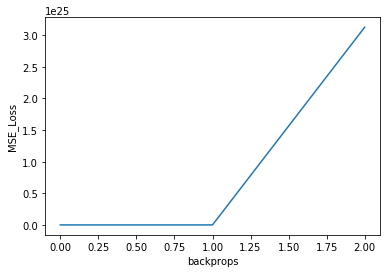

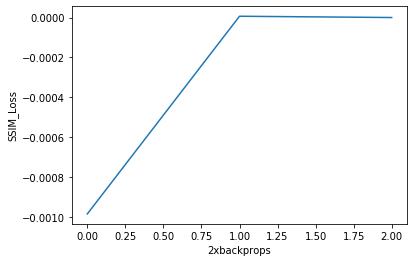

85.20396542549133 seconds# 1 minutes#
[-0.0009847829382379806, 6.434671576039031e-06, -2.040847983495137e-15, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

In [53]:
#losses=[]
#SSIMval=[]
#sec=1
torch.save({
    'model_state_dict': model.state_dict(),
    'optimiser_state_dict': optimiser.state_dict(),
    'Loss': losses,
    'SSIM': SSIMval,
    'Time': int(sec/60)
},model_path)
print(type(losses))
print(len(losses))
print(len(SSIMval))
plt.plot(range(len(losses)),losses,label="Training loss")
plt.xlabel("backprops")
plt.ylabel("MSE_Loss")
plt.show()
plt.plot(range(len(SSIMval)),SSIMval,label="SSIM loss")
plt.xlabel("2xbackprops")
plt.ylabel("SSIM_Loss")
plt.show()
print(sec,'seconds#',int(sec/60),'minutes#')
print(SSIMval)

In [ ]:
# Reconstruct the image
if cplx:
    fig = plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(x[0][0],cmap='gray')
    plt.title('Undersampled k-space image')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(y[0][0],cmap='gray')
    plt.axis('off')
    plt.show()
    fig = plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.imshow(x[0][0],cmap='gray')
    plt.title('Undersampled image')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(y[0][0],cmap='gray')
    plt.axis('off')
    plt.show()
else:
    

In [ ]:
print(Y_pred.shape)

In [ ]:
### clear GPU usage
torch.cuda.empty_cache()

In [ ]:
print((torch.Tensor.cpu(np.squeeze(y_train)).detach().numpy()).shape)
print((torch.Tensor.cpu(np.squeeze(Y_pred)).detach().numpy()).shape)
print(ssim(torch.Tensor.cpu(np.squeeze(y_train)).detach().numpy(), torch.Tensor.cpu(np.squeeze(Y_pred)).detach().numpy()))      # difference between cropped ground-truth with the undersampled/reconstructed image with acceleration factor of 8

### Inference

torch.Size([4, 1, 320, 320])
False
torch.Size([4, 1, 320, 320])


(-0.5, 319.5, 319.5, -0.5)

/bham/modules/roots/neural-comp/2019-20/lib64/python3.6/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/bham/modules/roots/neural-comp/2019-20/lib64/python3.6/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/bham/modules/roots/neural-comp/2019-20/lib64/python3.6/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/bham/modules/roots/neural-comp/2019-20/lib64/python3.6/site-packages/matplotlib/image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/bham/modules/roots/neural-comp/2019-20/lib64/python3.6/site-packages/numpy/ma/core.py:711: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subo

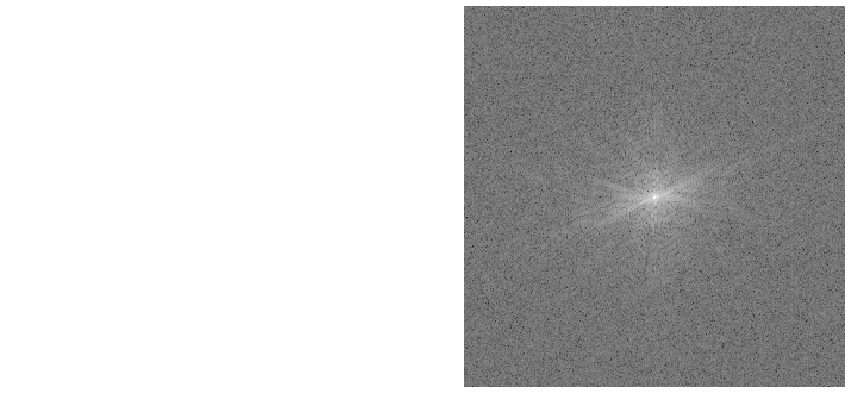

In [54]:
Y_Pred=torch.Tensor.cpu((Y_pred)).detach()
print(Y_pred.shape)
print(Y_Pred[0,0].requires_grad)
print(y_train.shape)
fig = plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(torch.Tensor.cpu(np.squeeze(Y_pred[0])).detach(),cmap='gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(torch.Tensor.cpu(np.squeeze(y_train[0])).detach(),cmap='gray')
plt.axis('off')